# Assignment #1
Riley Jackson<br>
Dr. Antonio Bolufe-Rohler<br>
February 25th, 2020<br>

## Chosen Dataset & Rational
The dataset examined in this assignment is the 'Forest Fire' dataset provided by
[Cortez and Morais, (2007)](https://repositorium.sdum.uminho.pt/handle/1822/8039).
This dataset of 517 examples poses a challenging multi-variate regression task, where 4-8 meteorological features are used to
predict the area (in Hectare) of forest burned in a day. These features are as follows:
0. Fine Fuel Moisture Code
1. Duff Moisture Code
2. Drought Code
3. Initial Spread Index
4. Temperature (in Celsius)
5. Relative Humidity (in percent)
6. Wind (in Km/h)
7. Rainfall (in mm/m<sup>2</sup>)

Regression algorithms are of particular importance in machine learning (ML) due to their adaptability. Indeed, regressors
are capable of predicting real, continuous values, but they may also be utilized for classification with minimal
modification. Regressors also fit more naturally into the description of ML as the study of generalized
function predictors, as one often thinks of a mathematical function as outputting a real value.

## Loading, Sanitizing, & Visualizing the Data
This dataset has several quirks which may influence both preprocessing and model selection. These include the
difference in feature scales, the bias towards little to no area burned for each day, and the inclusion of some
potentially irrelevant features. Before digging into these quirks, the data must first be loaded:

In [3]:
import numpy as np

# Define a function for convenience and to avoid global state
def get_data(first_feature: int = 4):
    data = np.genfromtxt('forestfires.csv', delimiter=',')  # load from .csv
    x = data[1:, first_feature:12]  # The .csv also contains location and time data, which is irrelevant to the prediction task
    y = data[1:, 12]

    return x, y

def check_stats():
    x, y = get_data()
    print('average area burned: {}'.format(np.mean(y)))
    [print('average value of feature {}: {}'.format(i, u)) for i, u in enumerate(np.mean(x, axis=0))]

check_stats()

average area burned: 12.847292069632493
average value of feature 0: 90.6446808510636
average value of feature 1: 110.87234042553195
average value of feature 2: 547.9400386847191
average value of feature 3: 9.021663442940042
average value of feature 4: 18.88916827852998
average value of feature 5: 44.28820116054158
average value of feature 6: 4.017601547388782
average value of feature 7: 0.02166344294003869


When looking at the average values of our features and our targets, the need for normalization is quite obvious.
Feature 1 has an average value of **~110**, while feature 7 has an average of **~0.02**. To make the prediction
task easier for our models, we can *normalize* our data.

Since this is a high dimensional dataset, it's quite difficult to visualize the data directly. We could attempt to
select only 1 - 2 features for plotting against our y value, but that leaves us with several different possible
plots. More effective is the use of dimensional reduction through **Principle Component Analysis** (PCA)
to project our data into a 2D or 3D space:

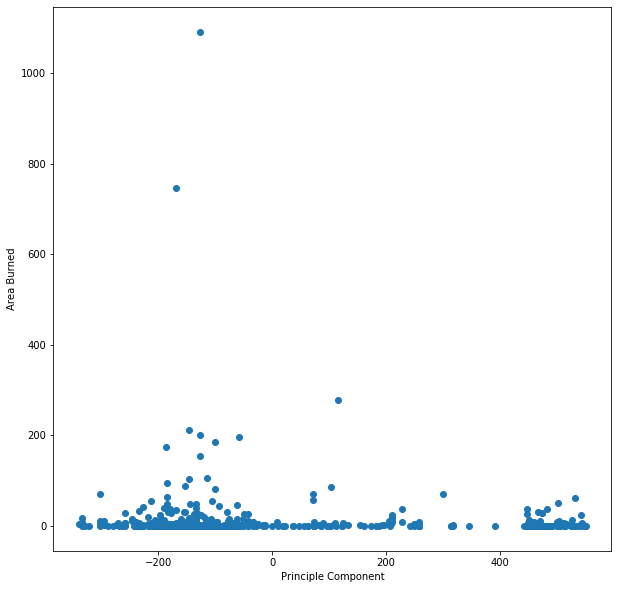

Total Variance ratio for PCA projection into R^1 space: 0.9626379470674843


In [4]:
from mpl_toolkits.mplot3d import Axes3D  # Require for matplotlib to plot in 3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def two_d_plot(fig, i, j):
    axis: plt.Axes = fig.add_subplot()
    axis.scatter(i, j)
    axis.set_xlabel('Principle Component')
    axis.set_ylabel('Area Burned')

def three_d_plot(fig, i, j, k):
    axis: plt.Axes = fig.add_subplot(111, projection='3d')
    axis.scatter(i, j, k,
    )
    axis.set_xlabel('Principle Component 1')
    axis.set_ylabel('Principle Component 2')
    axis.set_zlabel('Area Burned')

def plot_pca():
    x, y = get_data()
    n_components = 1  # Change this value to 2 to view a 3D plot
    pca = PCA(n_components=n_components)
    components = np.expand_dims(pca.fit_transform(x), axis=-1)  # (M, N, 1)

    fig = plt.figure(figsize=[10, 10])
    if n_components == 1:
        two_d_plot(fig, components, y)
    elif n_components == 2:
        three_d_plot(fig, components[:, 0], components[:, 1], y)

    plt.show()

    print('Total Variance ratio for PCA projection into R^{} space: {}'.format(
        n_components, np.sum(pca.explained_variance_ratio_)
    ))

plot_pca()

PCA is very useful for visualization, because now a single dimension represents all 8 of the original dataset
with a variance conservation of **~96%**. From the above plot we can see that our data is quite tightly packed
with-respect-to our y values, but there do exists some outliers. We can assume any regressor we train will
do poorly on these outliers as it will bias towards smaller areas. These handful of outliers and the overall
small number of examples in the dataset suggests we should attempt to use k-folds cross validation. Otherwise, we
run the risk of obtaining a static test split which varies greatly from our train split.

## Model Selection & Evaluation
Now that our data is fit for learning, we need to make decide which algorithms are applicable to our dataset. We can't
be sure our dataset is either linear or non-linear, so we should begin with **linear regression** (LR). Also, since our
targets are tightly packed, it may be beneficial to obtain compare our results to a 'mean predictor', which is a model
which only ever predicts the mean value of y. This provides us an sort of *upper bound* to our predictions, so we
know when a model is performing well.

LR has a **convex** loss landscape, meaning we can obtain a true line of best fit. It will also
let us know the degree of linearity in our data, and the parameters of the model can potentially give us some insight
into which features are most important in the prediction task:

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from functools import partial

cross_validate = partial(
    cross_validate,
    scoring='neg_mean_absolute_error',
    cv=5,
    return_train_score=True,
    return_estimator=True
)

def mean_predictor_mae():
    _, y = get_data()
    y_pred = np.empty_like(y)
    y_pred[:] = np.mean(y)
    return mean_absolute_error(y, y_pred)

def mean_results(results):
    return np.mean(
        np.absolute(
            results
        )
    )

def print_regressor_results(results, name='model'):
    print('CV TRAIN MAE for {}: {}'.format(name, mean_results(results['train_score'])))
    print('CV TEST MAE for {}: {}'.format(name, mean_results(results['test_score'])))

def evaluate_linear_regression():
    x, y = get_data()
    results = cross_validate(
        LinearRegression(normalize=True),
        x,
        y
    )
    print_regressor_results(results, 'LR')
    print('Mean Predictor MAE: {}'.format(mean_predictor_mae()))
    [print('Param for feature {}: {}'.format(i, p)) for i, p in enumerate(results['estimator'][0].coef_)]

evaluate_linear_regression()

CV TRAIN MAE for LR: 19.247269660445614
CV TEST MAE for LR: 21.020804726378245
Mean Predictor MAE: 18.566830958251177
Param for feature 0: -0.029429883920658102
Param for feature 1: 0.05999250030608885
Param for feature 2: -0.0004943516814239611
Param for feature 3: -1.0100044550537683
Param for feature 4: 0.9560307654797862
Param for feature 5: -0.29647143355574784
Param for feature 6: 2.0512882238202885
Param for feature 7: -2.6494255844916923


We can see from the above results that LR performs worse than a simple mean predictor, and we observe a slight
difference between train and test results. This is likely due to the test set not being reflective of the train
set, but it may also indicate **overfitting**. It's always worth adding some **regularization** to combat overfitting,
so we can make note of that when deciding on our next model. Also, it may be likely that the dataset is non-linear,
so we should attempt to fit a **non-linear** model. Lastly, as suggested by the authors of this dataset, the parameters
for features 0 - 2 are quite **small**, suggesting they are less important in the prediction task.
It may be beneficial to only make predictions using **features 3 - 7** moving forward.

We'll begin by testing the **feature selection** of features 3 - 7 only:

In [6]:
def evaluate_linear_regression_with_feature_selection():
    x, y = get_data(first_feature=8)  # Select elements [8 - 12) of .csv rows
    results = cross_validate(
        LinearRegression(normalize=True),
        x,
        y
    )
    print_regressor_results(results, 'LR')

evaluate_linear_regression_with_feature_selection()

CV TRAIN MAE for LR: 19.06048325052673
CV TEST MAE for LR: 20.395378491493904


We observe slightly better results, although very minor.

Since we didn't observe a significant difference in the test/train errors, we'll next test out a non-linear model.
The most simple example of this is a polynomial regressor:

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def evaluate_polynomial_regressor():
    x, y = get_data(8)
    for degree in [2, 4, 8]:
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('regressor', LinearRegression(False, normalize=True))
        ])
        results = cross_validate(
            model,
            x,
            y
        )
        print_regressor_results(results, 'Poly LR with degree {}'.format(degree))

evaluate_polynomial_regressor()

CV TRAIN MAE for Poly LR with degree 2: 18.753777239557742
CV TEST MAE for Poly LR with degree 2: 21.564333481864704
CV TRAIN MAE for Poly LR with degree 4: 19.093717511253264
CV TEST MAE for Poly LR with degree 4: 24.904667911903637
CV TRAIN MAE for Poly LR with degree 8: 22.542648791757408
CV TEST MAE for Poly LR with degree 8: 110114.34251892597


As we increase the degree of the polynomial, we observe *severe* overfitting. We also notice a slight decrease in
performance on the training set. A polynomial regressor is likely not optimal for this prediction task, something
we could have anticipated. Non-linear regressors are very susceptible for overfitting at high polynomial degrees. Also,
their cost landscapes are *non-convex*, meaning they must be minimized using iterative methods, e.g. by
gradient descent. Non-convex functions also denote the presence of **local minima**, so polynomial regressors
can be somewhat unstable. There do exist other ML algorithms for learning on non-linear data more fit for this
task that we shall discuss next.

From the LR and polynomial regressors we previously studied we observed two major requirements from our model:
1. We need to utilize some amount of **regularization** to ensure we don't overfit our data
2. We should try another form of **non-linear** fitting

A class of models that fit these two requirements are the **kernel ridge regressors** (KRR). KRRs utilize the
kernel trick of transforming our data into a new, potentially linear space, and they also employ l2-regularization
for combatting overfitting. Unlike LR, they also have an ample amount of hyperparameters that can be tuned
to squeeze out as much performance as possible. `sklearn` has an easily tunable KRR class we can attempt
to fit to our dataset:

In [8]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

def evaluate_krr():
    x, y = get_data(first_feature=8)  # Select elements [8 - 12) of .csv rows
    search_space = {  # 16 total models
        'alpha': [0.1, 1, 10, 100],  # alpha = lambda / 2, where lambda is the level of regularization used
        'kernel': ['rbf'],  # linear doesn't transform the space, rbf uses a Gaussian kernel
        'gamma': [0.1, 1, 10, 100]  # Width of the Gaussian, denotes the amount of influence each example has in the transformation
    }
    model = GridSearchCV(
        KernelRidge(),
        search_space,
        scoring='neg_mean_absolute_error',
        cv=5,
        return_train_score=True
    )
    model = model.fit(x, y)
    print('Best model params: {}'.format(model.best_params_))
    results = cross_validate(model.best_estimator_, x, y)
    print_regressor_results(results, 'Best KRR')

    worst_params = model.cv_results_['params'][0]
    worst_results = cross_validate(KernelRidge(**worst_params), x, y)
    print('Worst model params: {}'.format(worst_params))
    print_regressor_results(worst_results, 'Worst KRR')


evaluate_krr()

Best model params: {'alpha': 100, 'gamma': 100, 'kernel': 'rbf'}
CV TRAIN MAE for Best KRR: 12.720311064523774
CV TEST MAE for Best KRR: 12.893793113959635
Worst model params: {'alpha': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
CV TRAIN MAE for Worst KRR: 12.771171662255437
CV TEST MAE for Worst KRR: 27.4289639492486


KRR performs very well on this dataset, obtaining the lowest MAE values tested yet. This error, **12.89 Ha**,
is very close to the  **12.72 Ha** value obtained by the model proposed by the original authors, Cortez and Morais. They utilized
**support vector regression** (SVR), a modified SVM designed for regression tasks.
SVR and KRR are almost identical, as they both utilized l2-regularization and the kernel trick. Their major difference
is their cost functions; KRR uses mean squared error, while SVR uses the hinge loss.

SVR and KRR often converge to similar results, so it is possible that the **0.17 Ha** difference in performance
is due to the relatively small size of our KRR search space. This small search space was chosen to
conserve computational time and resources while still demonstrating the possible spread of model performance.
As we can see, our worst performing KRR model still performs quite well on the *train set*, but we can see that
it has overfit our data quite significantly. Since $\alpha \propto \lambda$, where lambda controls the level of
regularization utilized when training the model, the performance of the worst model makes sense when we view its
parameters, as $\alpha = 0.1$.

Lastly, we should attempt to understand the bias of our best KRR model. From our PCA plot, we suspected that our models
will perform poorly on examples with a large area burned. We can confirm this by sorting our model's predictions
by the largest errors view the examples that produced these errors:

In [41]:
from sklearn.model_selection import train_test_split

def check_worst_examples():
    x, y = get_data(8)
    model = KernelRidge(alpha=100, kernel='rbf', gamma=100)
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    worst_examples = np.argsort(np.absolute(y_test - y_pred))[::-1]  # Sort in descending order
    np.set_printoptions(formatter={'float': lambda l: "{0:0.2f}".format(l)})  # Ensure not to print in scientific not.
    print(y_test[worst_examples])

check_worst_examples()

[746.28 174.63 43.32 40.54 31.72 30.32 30.18 28.19 27.35 24.23 16.33 15.34
 14.29 13.70 11.32 11.24 11.22 10.02 9.96 9.41 8.68 8.24 8.00 7.80 7.36
 6.96 6.84 6.83 6.61 6.36 6.30 6.10 5.80 5.55 3.93 3.19 3.05 2.87 2.74
 2.69 2.57 2.44 2.29 2.18 2.14 2.01 2.00 1.94 1.63 1.63 1.46 1.36 1.26
 1.07 0.95 1.01 0.72 0.71 0.54 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


The largest values **always** appear at the top of our array sorted by worst performance, even if the train set
contains a large amount of high valued y's. This confirms our suspicions that our best model is biased towards
predicting smaller burn areas.

From the three model types tests, we can suggest that the Forest Fire dataset is a non-trivial prediction task.
The data appears to be non-linear, as evidented by the increase in performance when applying the kernel trick
with KRR. Also, a number of features seem to be irrelevant to the prediction task. These irrelevant features
are the first four features of the dataset:

0. Fine Fuel Moisture Code
1. Duff Moisture Code
2. Drought Code
3. Initial Spread Index

While the relevant features are:

4. Temperature (in Celsius)
5. Relative Humidity (in percent)
6. Wind (in Km/h)
7. Rainfall (in mm/m<sup>2</sup>)

This suggests that with only meteorological data one can predict the burned area of a forest within a reasonable error
margin of $\pm13$ Hectare. However, our models are not without bias. Since the Forest Fire dataset is skewed towards
smaller burn areas, this is reflected in our model. A model is only as good as the data it is trained upon, so it
is likely this bias will be intrinsic to all models trained on this dataset.
